# Testing clustering with the Porto Dataset

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
from scripts.function_utils import select_past_timesteps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, 
import re
import time
import math

In [2]:
df = pd.read_csv("../datasets/Dataset.csv", decimal=",")
df_index = pd.DataFrame(pd.date_range('2019-01-01', periods=35136, freq='15T'))
df = pd.concat([pd.DataFrame(df_index).rename(columns={0: "Time"}),df],axis=1)
df = df.drop(["0"], axis=1)
df

,Time,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 00:15:00,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,2019-01-01 00:30:00,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2019-01-01 00:45:00,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2019-01-01 01:00:00,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2020-01-01 22:45:00,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,2020-01-01 23:00:00,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,2020-01-01 23:15:00,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,2020-01-01 23:30:00,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


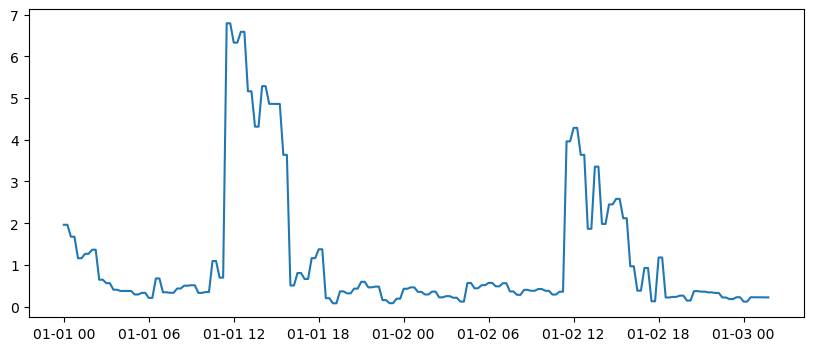

In [145]:
plt.figure(figsize=(10,4))
plt.plot(df.iloc[:200,0],df.iloc[:200,4])
plt.show()

In [160]:
undersample_data = df.loc[np.linspace(df.index.min(),df.index.max(),3000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,Time,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 02:45:00,2.443886,0.508011,0.255981,0.645293,2.816826,0.236496,0.685193,0.317444,0.809914,...,0.945689,0.202642,0.220337,0.282918,0.874256,0.973139,0.217856,0.273284,1.042051,0.820053
2,2019-01-01 05:45:00,2.208429,0.259545,0.130782,0.329682,2.545438,0.086792,0.251459,0.209140,0.297230,...,0.854576,0.074367,0.080861,0.186393,0.790025,0.879381,0.079951,0.100293,0.941654,0.741044
3,2019-01-01 08:45:00,2.244719,0.395647,0.199362,0.502565,2.587266,0.195787,0.567247,0.425748,0.670499,...,0.868619,0.167760,0.182409,0.379444,0.803007,0.893832,0.180355,0.226243,0.957128,0.753222
4,2019-01-01 11:30:00,2.382500,5.347570,2.694579,6.792662,2.746072,0.414973,1.202286,0.179262,1.421130,...,0.921935,0.355569,0.386618,0.159766,0.852296,0.948695,0.382264,0.479524,1.015876,0.799454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2020-01-01 12:00:00,1.290956,0.246884,0.124402,0.313600,1.487958,1.117284,3.237067,0.130712,3.826288,...,0.499550,0.957343,1.040941,0.116496,0.461816,0.514050,1.029218,1.291082,0.550452,0.433184
2996,2020-01-01 14:45:00,0.885487,0.324431,0.163477,0.412103,1.020614,1.712793,4.962414,0.268894,5.865689,...,0.342649,1.467604,1.595760,0.239649,0.316767,0.352595,1.577789,1.979225,0.377564,0.297128
2997,2020-01-01 17:45:00,1.535517,3.203161,1.614036,4.068762,1.769839,0.989035,2.865495,0.276363,3.387082,...,0.594185,0.847453,0.921455,0.246305,0.549303,0.611433,0.911078,1.142883,0.654731,0.515247
2998,2020-01-01 20:45:00,1.589276,1.436991,0.724083,1.825314,1.831802,1.660324,4.810397,0.052285,5.686002,...,0.614988,1.422646,1.546876,0.046598,0.568535,0.632839,1.529456,1.918594,0.677653,0.533286


In [ ]:
plt.plot(undersample_data.Time,undersample_data["5"])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [162]:
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
undersmpl = pd.DataFrame(scaler.fit_transform(undersample_data.drop('Time', axis=1)).reshape(3000,50))

In [75]:
n_clusters = 16

In [8]:
from tqdm import tqdm
data_array = np.array(undersmpl.T.values)
cities_list = undersmpl.T.index.tolist()
inertia_list = []
cluster_list = []
model_list = []
for c in tqdm(range(2, n_clusters + 1)):
    model = TimeSeriesKMeans(n_clusters=c, metric="dtw", max_iter=10, n_init=3, dtw_inertia=True)
    model.fit(data_array)
    model_list.append(model)
    inertia_list.append(model.inertia_)
    cluster_list.append(model.labels_)

100%|██████████| 11/11 [1:39:55<00:00, 545.01s/it]


In [9]:
for c in tqdm(range( n_clusters + 1, 17)):
    model = TimeSeriesKMeans(n_clusters=c, metric="dtw", max_iter=10, n_init=3, dtw_inertia=True)
    model.fit(data_array)
    model_list.append(model)
    inertia_list.append(model.inertia_)
    cluster_list.append(model.labels_)

100%|██████████| 4/4 [49:58<00:00, 749.54s/it]


Text(0, 0.5, 'Inertia')

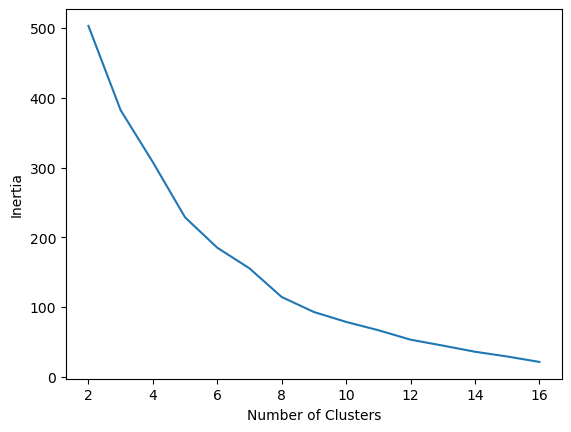

In [10]:
plt.plot(range(2,17), inertia_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

In [12]:
sourceFile = open("clusters.txt", 'w')

In [13]:
print("Cluster List\n", file=sourceFile)
print(cluster_list, file=sourceFile)
print("Inertia List\n", file=sourceFile)
print(inertia_list, file=sourceFile)
print("Model List\n", file=sourceFile)
print(model_list, file=sourceFile)

In [14]:
sourceFile.close()

In [151]:
def read_clusters_from_file(filename):
    all_clusters = []
    readFile = open(filename, 'r')
    file = readFile.readlines()
    clcl = file[2:n_clusters+1]
    for c in clcl:
        clcli = list(c.split(","))
        clcli[0] = clcli[0].split("[")[-1]
        clcli.pop() ## pop \n element
        house_list = np.array(clcli)
        cluster_list = []
        for i in house_list:
            result = re.sub(r'[^0-9]','',i)
            cluster_list.append(int(result))
        cluster_list = np.array(cluster_list)
        all_clusters.append(cluster_list)
    return all_clusters

In [152]:
def split_into_clusters(cluster):
    clstr_lst = []
    for i in range(len(np.unique(cluster))):
        clstr_lst.append(np.where(cluster == i)[0])
    return clstr_lst

In [174]:
def dataframe_by_cluster(cl_list, df):
    clusters = []
    for i in cl_list:
        dataframe = df.iloc[:, i]
        clusters.append(dataframe)
    return clusters

In [197]:
cluster_list

array([ 5,  8,  2, 13,  1,  7, 11, 14,  4,  7,  4,  3, 10,  8,  5,  7,  0,
       12,  0,  7,  6,  7,  1,  6, 12,  5,  0,  9,  9, 15, 14, 11,  1, 12,
        0,  6,  1, 10, 10,  7,  2,  7,  7, 14,  2,  2,  7,  7,  2,  2])

In [ ]:
# Executed with 1-hour intervals
#y = np.array([1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [23]:
x = undersample_data['Time']

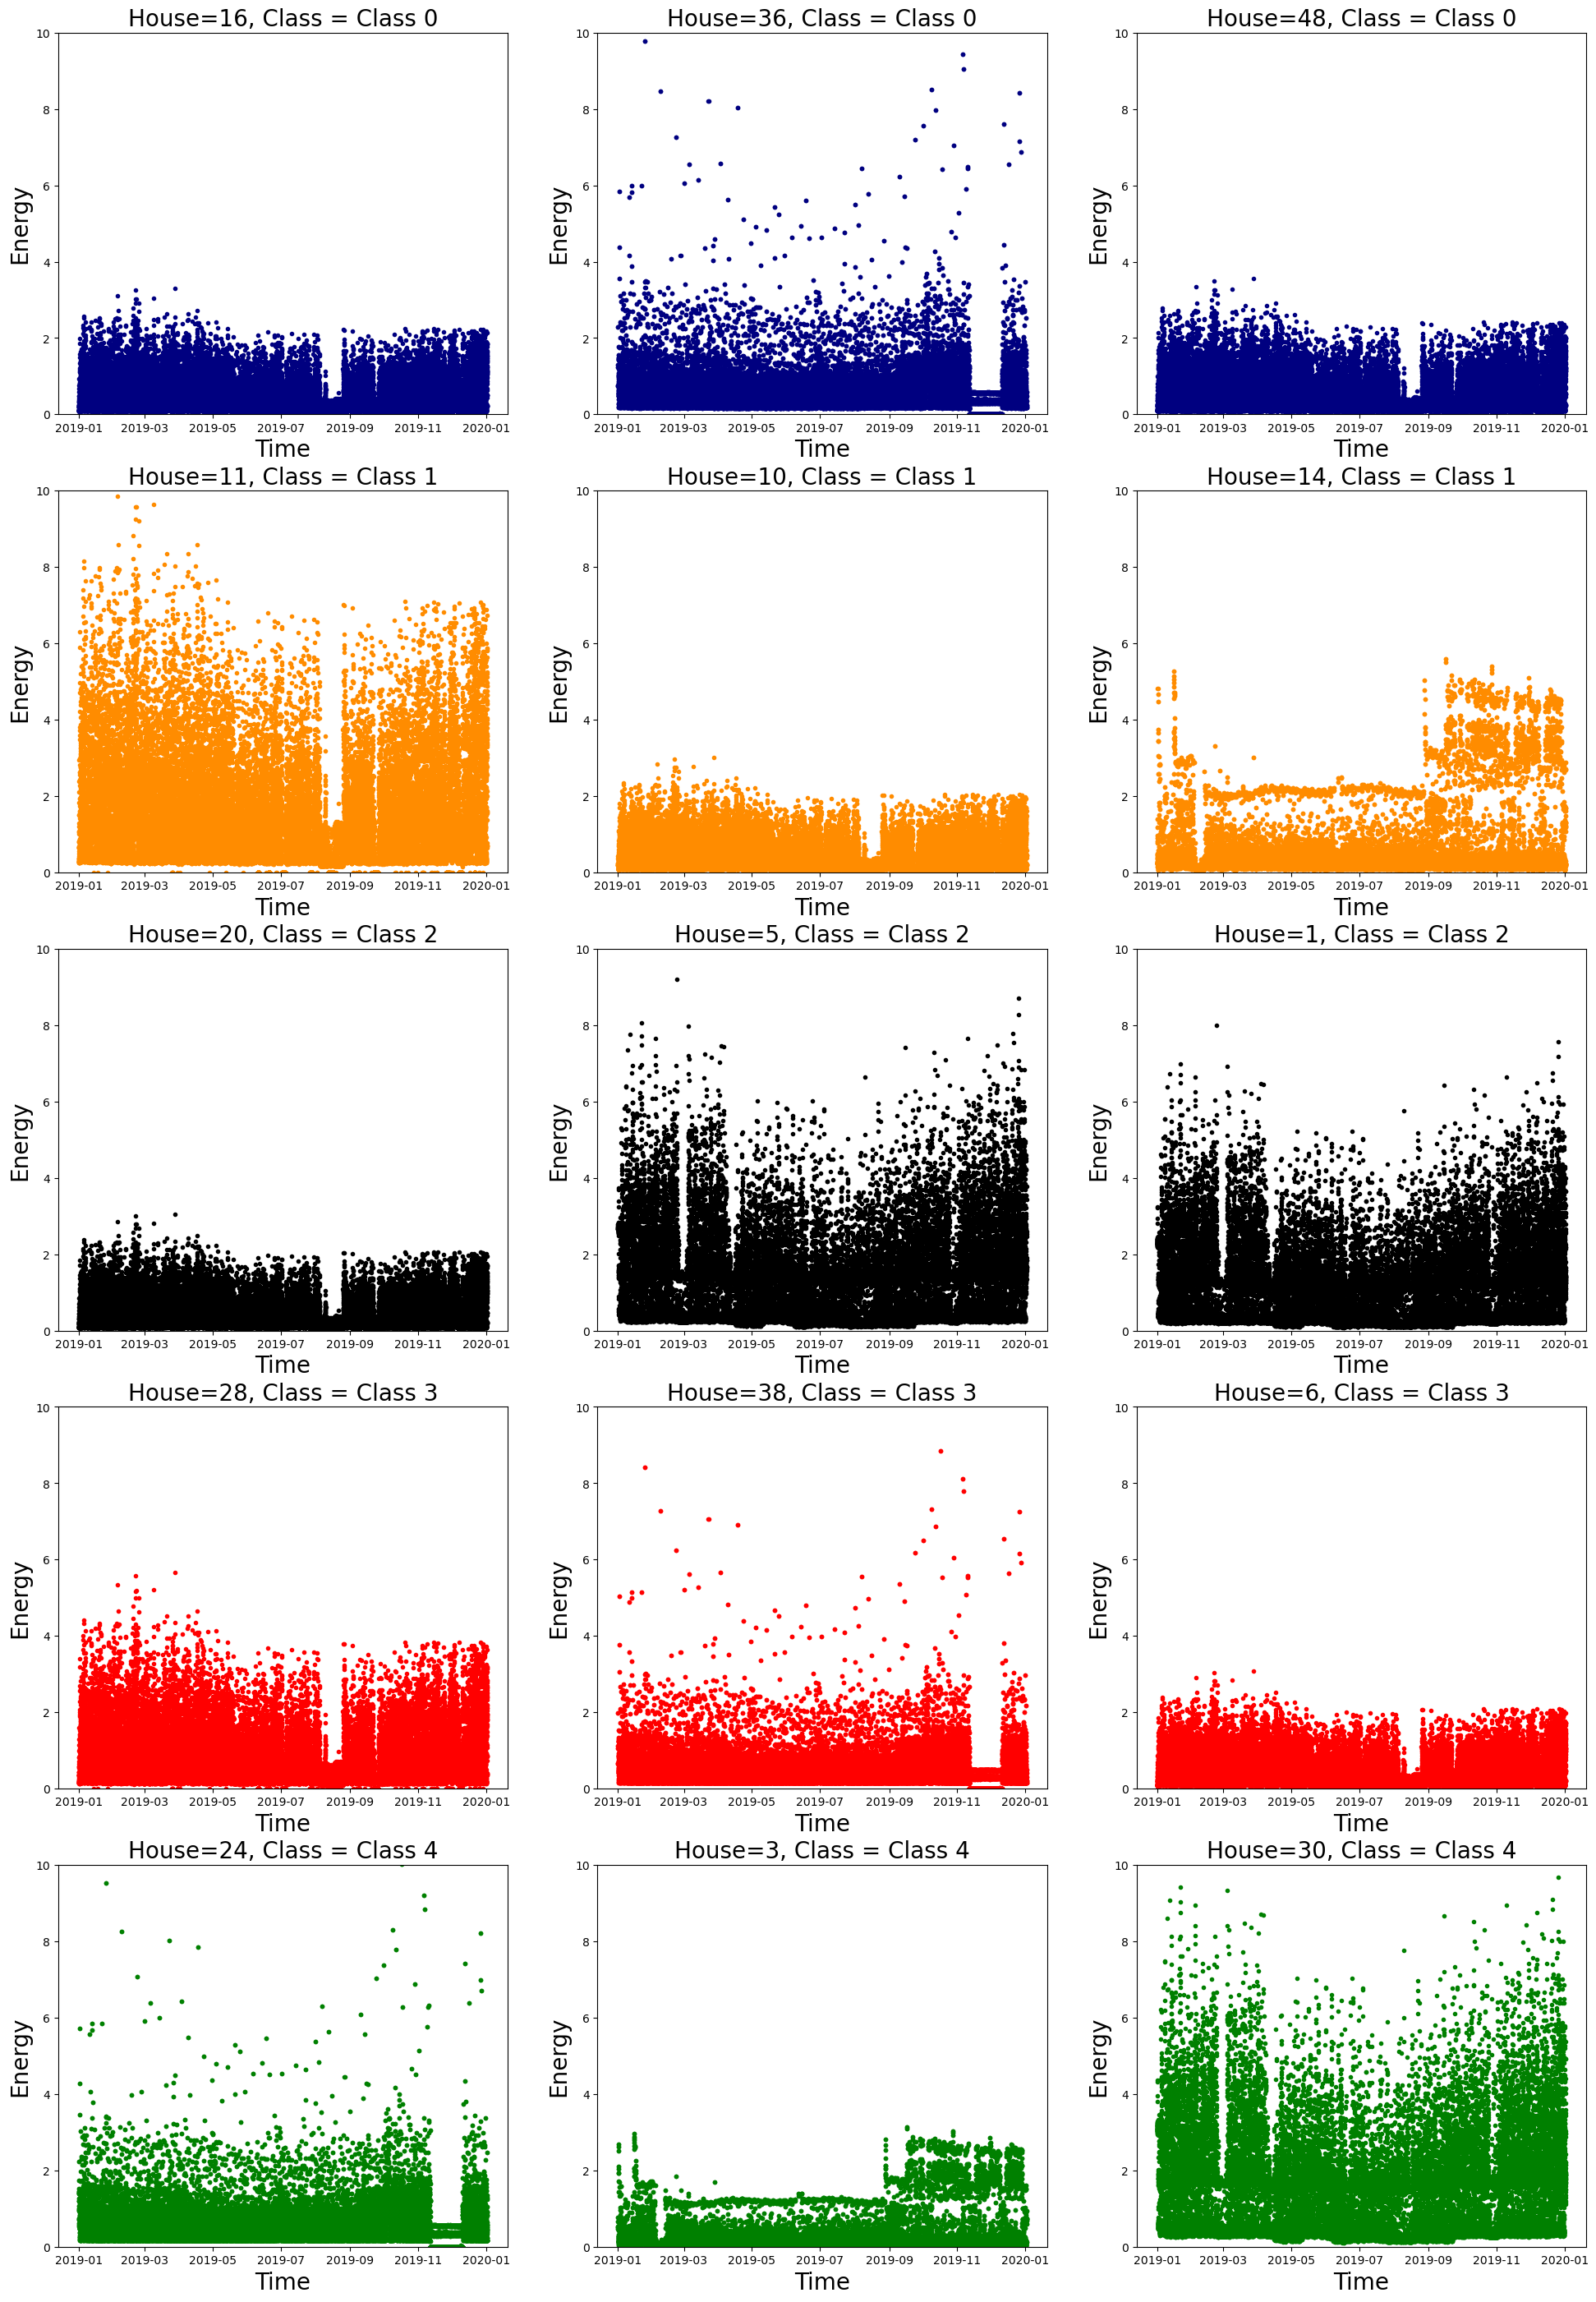

In [28]:
plt.figure(figsize=(24,35))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2,'10':3, '11':3, '12':3, '13':4, '14':4, '15':4}
colors = ['navy']*3+['darkorange']*3+['k']*3+['red']*3+['green']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3+['Class 3']*3+['Class 4']*3
for j in range(1,16):
    plt.subplot(5,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(df.Time,df["{}".format(k)],'.',color=colors[j-1])
    plt.ylabel('Energy',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('House=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(0,10)

In [ ]:
cluster_list = []
for i in range(0,n_clusters):
    cluster_list.append(np.where(y == i)[0])
len(cluster_list)

In [ ]:
string = "cluster"
for i in range(len(cluster_list)):
    st = string + str(i)
    locals()[st] = cluster_list[i]
    print(cluster_list[i])

In [ ]:
cluster0

In [ ]:
#cluster0.to_csv("data/.csv", index=None)

In [ ]:
#cluster2.to_csv("data/.csv", index=None)

In [ ]:
## Compare gains of cluster with normal runs